In [1]:
# 01_quicklook.ipynb 顶部第一格
from pathlib import Path
import duckdb, os

def get_con():
    BASE = Path("../data")
    DB   = BASE / "warehouse.duckdb"
    TMP  = BASE / "warehouse.duckdb.tmp"
    BASE.mkdir(exist_ok=True); TMP.mkdir(exist_ok=True)
    return duckdb.connect(
        str(DB),
        config={"temp_directory": TMP.as_posix(), "threads": 2, "memory_limit": "6GB"},
    )

con = get_con()
con.execute("CREATE SCHEMA IF NOT EXISTS staging")
con.execute("CREATE SCHEMA IF NOT EXISTS core")
con.execute("CREATE SCHEMA IF NOT EXISTS features")

In [2]:
BTC_PARQ = "../data/warehouse/btc_usdt_daily.parquet"
BTC_CSV  = "../data/warehouse/btc_usdt_daily.csv"

# 看看 parquet 有没有
import os
if os.path.exists(BTC_PARQ):
    con.execute("""
        CREATE OR REPLACE TABLE staging.mkt_raw AS
        SELECT * FROM read_parquet($1)
    """, [BTC_PARQ])
else:
    con.execute("""
        CREATE OR REPLACE TABLE staging.mkt_raw AS
        SELECT * FROM read_csv_auto($1, AUTO_DETECT=TRUE, SAMPLE_SIZE=-1)
    """, [BTC_CSV])

con.execute("SELECT * FROM staging.mkt_raw LIMIT 5").df()


,timestamp,close
0,1596240000,11811.42
1,1596326400,11079.72
2,1596412800,11227.07
3,1596499200,11200.05
4,1596585600,11752.50


In [3]:
USERS_CSV = "../data/raw/subsampled_users.csv"

con.execute("""
    CREATE OR REPLACE TABLE staging.logs_raw AS
    SELECT * FROM read_csv_auto($1, AUTO_DETECT=TRUE, SAMPLE_SIZE=-1)
""", [USERS_CSV])

con.execute("SELECT * FROM staging.logs_raw LIMIT 5").df()


,id,timestamp,pnl,margin
0,6E45B3DD651F1208CBF36734B940FA26,1614556800,0.0,-1.0
1,6E45B3DD651F1208CBF36734B940FA26,1614643200,0.0,-1.0
2,6E45B3DD651F1208CBF36734B940FA26,1614729600,0.0,-1.0
3,6E45B3DD651F1208CBF36734B940FA26,1614816000,0.0,-1.0
4,6E45B3DD651F1208CBF36734B940FA26,1614902400,0.0,-1.0


In [4]:
con.execute("""
CREATE OR REPLACE TABLE core.mkt AS
WITH src AS (
  SELECT
    CAST(
      to_timestamp(
        CASE
          WHEN typeof(timestamp)='BIGINT' AND timestamp > 1000000000000 THEN timestamp/1000
          WHEN typeof(timestamp)='BIGINT' THEN timestamp
          ELSE NULL
        END
      ) AS DATE
    )                      AS dt,
    CAST(close AS DOUBLE)  AS close
  FROM staging.mkt_raw
)
SELECT
  dt,
  close,
  (ln(close) - ln(lag(close) OVER (ORDER BY dt))) AS r_mkt,
  CASE
    WHEN (ln(close) - ln(lag(close) OVER (ORDER BY dt))) > 0 THEN 1
    WHEN (ln(close) - ln(lag(close) OVER (ORDER BY dt))) < 0 THEN -1
    ELSE 0
  END AS dir
FROM src
WHERE dt IS NOT NULL
ORDER BY dt;

""")

con.execute("SELECT * FROM core.mkt LIMIT 5").df()


,dt,close,r_mkt,dir
0,2020-07-31,11811.42,NaN,0
1,2020-08-01,11079.72,-0.063950,-1
2,2020-08-02,11227.07,0.013211,1
3,2020-08-03,11200.05,-0.002410,-1
4,2020-08-04,11752.50,0.048148,1


In [5]:
con.execute("""
CREATE OR REPLACE TABLE core.logs_clean AS
SELECT
  id::TEXT                AS id,
  timestamp::BIGINT       AS ts,
  pnl::DOUBLE             AS cum_pnl,       -- 累计PnL（账户创建到当日）
  NULLIF(margin,-1)::DOUBLE AS margin       -- -1 视为缺失
FROM staging.logs_raw;
""")

con.execute("SELECT * FROM core.logs_clean LIMIT 5").df()


,id,ts,cum_pnl,margin
0,6E45B3DD651F1208CBF36734B940FA26,1614556800,0.0,NaN
1,6E45B3DD651F1208CBF36734B940FA26,1614643200,0.0,NaN
2,6E45B3DD651F1208CBF36734B940FA26,1614729600,0.0,NaN
3,6E45B3DD651F1208CBF36734B940FA26,1614816000,0.0,NaN
4,6E45B3DD651F1208CBF36734B940FA26,1614902400,0.0,NaN


In [6]:
con.execute("""
CREATE OR REPLACE TABLE core.user_periods AS
WITH ordered AS (
  SELECT
    id, ts, cum_pnl,
    LAG(cum_pnl) OVER (PARTITION BY id ORDER BY ts) AS cum_pnl_prev
  FROM core.logs_clean
)
SELECT
  id,
  ts,
  CAST(to_timestamp(ts) AS DATE) AS d,
  cum_pnl,
  (cum_pnl - COALESCE(cum_pnl_prev,0)) AS pnl
FROM ordered
ORDER BY id, ts;
""")

con.execute("SELECT * FROM core.user_periods LIMIT 5").df()


,id,ts,d,cum_pnl,pnl
0,000422C981A26DFB6A1C56268FED742F,1628640000,2021-08-10,0.0,0.0
1,000422C981A26DFB6A1C56268FED742F,1628726400,2021-08-11,0.0,0.0
2,000422C981A26DFB6A1C56268FED742F,1628812800,2021-08-12,0.0,0.0
3,000422C981A26DFB6A1C56268FED742F,1628899200,2021-08-13,0.0,0.0
4,000422C981A26DFB6A1C56268FED742F,1628985600,2021-08-14,0.0,0.0


In [7]:
con.execute("""
CREATE OR REPLACE TABLE core.user_dir AS
SELECT
  u.id, u.ts, u.d, u.cum_pnl, u.pnl,
  CASE WHEN u.pnl>0 THEN 1 WHEN u.pnl<0 THEN -1 ELSE 0 END AS S,
  m.r_mkt,
  m.dir AS mkt_dir
FROM core.user_periods u
LEFT JOIN core.mkt m
  ON u.d = m.dt;
""")

con.execute("SELECT id, d, S, r_mkt, mkt_dir FROM core.user_dir LIMIT 5").df()


,id,d,S,r_mkt,mkt_dir
0,00971D0C3B15C197473401BEC4397C16,2023-06-19,0,0.053065,1
1,00971D0C3B15C197473401BEC4397C16,2023-06-20,0,0.058284,1
2,00971D0C3B15C197473401BEC4397C16,2023-06-21,0,-0.003792,-1
3,00971D0C3B15C197473401BEC4397C16,2023-06-22,0,0.026374,1
4,00971D0C3B15C197473401BEC4397C16,2023-06-23,0,-0.004876,-1


In [9]:
con.execute("""
SELECT
  COUNT(*)                                                   AS total_rows,
  COUNT(*) FILTER (WHERE margin IS NULL)                     AS n_margin_missing,
  COUNT(*) FILTER (WHERE margin IS NOT NULL)                 AS n_margin_present,
  1.0 * COUNT(*) FILTER (WHERE margin IS NOT NULL) / COUNT(*) AS frac_present
FROM core.logs_clean
""").df()

,total_rows,n_margin_missing,n_margin_present,frac_present
0,61566083,55282123,6283960,0.102069


In [10]:
con.execute("""
CREATE OR REPLACE TABLE core.user_margin_coverage AS
SELECT
  id,
  COUNT(*)                                                   AS n_rows,
  COUNT(*) FILTER (WHERE margin IS NOT NULL)                 AS n_with_margin,
  AVG(CASE WHEN margin IS NOT NULL THEN 1.0 ELSE 0.0 END)   AS frac_with_margin
FROM core.logs_clean
GROUP BY id
""")

# 有多少用户至少有一次 margin
con.execute("""
SELECT
  COUNT(*)                                       AS n_users,
  COUNT(*) FILTER (WHERE n_with_margin > 0)      AS n_users_with_margin,
  1.0 * COUNT(*) FILTER (WHERE n_with_margin > 0) / COUNT(*) AS frac_users_with_margin
FROM core.user_margin_coverage
""").df()

# 覆盖率分位数（用户层面）
con.execute("""
SELECT
  approx_quantile(frac_with_margin, 0.00) AS q0,
  approx_quantile(frac_with_margin, 0.25) AS q25,
  approx_quantile(frac_with_margin, 0.50) AS q50,
  approx_quantile(frac_with_margin, 0.75) AS q75,
  approx_quantile(frac_with_margin, 1.00) AS q100
FROM core.user_margin_coverage
""").df()


,q0,q25,q50,q75,q100
0,0.02164,0.049651,0.090706,0.173897,0.761306


In [13]:
# 3) 随机抽一个“至少出现过一次 margin”的用户
uid = con.execute("""
SELECT id
FROM core.user_margin_coverage
WHERE n_with_margin > 0
LIMIT 1
""").df().iloc[0,0]
uid


'6E45B3DD651F1208CBF36734B940FA26'

In [15]:
con.execute(f"""
SELECT
  id,
  ts,
  CAST(to_timestamp(ts) AS DATE) AS d,
  cum_pnl,
  margin
FROM core.logs_clean
WHERE id = '{uid}' AND margin IS NOT NULL
ORDER BY ts
LIMIT 200
""").df()

,id,ts,d,cum_pnl,margin
0,6E45B3DD651F1208CBF36734B940FA26,1701561600,2023-12-02,52.258892,49.739720
1,6E45B3DD651F1208CBF36734B940FA26,1701648000,2023-12-03,52.195854,48.832570
2,6E45B3DD651F1208CBF36734B940FA26,1701734400,2023-12-04,51.289440,48.463905
3,6E45B3DD651F1208CBF36734B940FA26,1701820800,2023-12-05,50.920734,46.367664
4,6E45B3DD651F1208CBF36734B940FA26,1701907200,2023-12-06,48.824380,47.187706
...,...,...,...,...,...
60,6E45B3DD651F1208CBF36734B940FA26,1709078400,2024-02-27,41.412080,40.094090
61,6E45B3DD651F1208CBF36734B940FA26,1709164800,2024-02-28,42.550888,47.380500
62,6E45B3DD651F1208CBF36734B940FA26,1709251200,2024-02-29,49.837254,64.864510
63,6E45B3DD651F1208CBF36734B940FA26,1709424000,2024-03-02,62.758972,63.654922


In [16]:
con.execute("""
CREATE OR REPLACE TABLE tmp_returns_margin AS
WITH base AS (
  SELECT
    u.id,
    u.ts,
    CAST(to_timestamp(u.ts) AS DATE) AS d,
    u.pnl,
    m.margin
  FROM core.user_periods u
  JOIN core.logs_clean m
    ON u.id = m.id AND u.ts = m.ts
  WHERE m.margin IS NOT NULL
),
lagged AS (
  SELECT
    id, ts, d, pnl, margin,
    LAG(margin) OVER (PARTITION BY id ORDER BY ts) AS margin_prev
  FROM base
)
SELECT
  id, ts, d, pnl, margin_prev,
  CASE
    WHEN margin_prev > 0 THEN pnl / margin_prev
    ELSE NULL
  END AS ret
FROM lagged;
""")

# 2) 每个用户的“仅有 margin 日”的日收益波动率
con.execute("""
CREATE OR REPLACE TABLE user_vol_margin AS
SELECT
  id,
  STDDEV_POP(ret) AS sigma_margin,
  COUNT(*) FILTER (WHERE ret IS NOT NULL) AS n_ret_obs
FROM tmp_returns_margin
GROUP BY id;
""")

# 看前几行
con.execute("SELECT * FROM user_vol_margin LIMIT 10").df()

,id,sigma_margin,n_ret_obs
0,6CD4573E638C182CCC590628B58FF5DA,5.311359e-02,125
1,6D802ECA84578083614DED45A04251D9,1.356728e+00,125
2,6E97CD043C1331A559BFC647928F58B7,7.974032e-02,97
3,6F605A62AB4A5E85537D85C9BFCFB556,9.240364e-02,223
4,73B3AA9D010F08046C33EF2B8253A991,1.900504e-01,98
5,742DF541FEA1BFF3732AAE8086055870,9.731194e-02,116
6,745008E844AA18D9EDD22493D3CD4D2D,8.451385e-01,44
7,74B164E77710FDC6B6C4DF25730D2269,2.036411e+00,39
8,757A894EDCD88AB909CDFC7B4666BFB5,1.182301e+06,62
9,760D91736AC21224707EC0EC76BFE064,1.355463e+00,35


In [17]:
# 账户方向 & 市场方向一致的频率
con.execute("""
CREATE OR REPLACE TABLE user_dirhit AS
SELECT
  id,
  AVG(CASE WHEN S IS NOT NULL AND mkt_dir IS NOT NULL AND S = mkt_dir THEN 1.0 ELSE 0.0 END) AS dir_hit_rate,
  COUNT(*) AS n_days
FROM core.user_dir
GROUP BY id;
""")

con.execute("SELECT * FROM user_dirhit LIMIT 10").df()


,id,dir_hit_rate,n_days
0,010C7D0C0E46832FF02071A237E77A7F,0.246804,1799
1,011E53D44040CB509BE624012476A60A,0.240991,1332
2,011EB4EFE711FFC739D0A76B057EA22A,0.126157,864
3,011FB5ECAFB49D58A75669A237BF3793,0.057766,1835
4,0126F612D01D2EDCF31B6D36616C01E1,0.124138,870
5,0129483D26ED89670441D8F8542D0816,0.217129,1658
6,012B7CB3B6EEF6B51C33E842BEE5638F,0.343457,1811
7,012E88DFC168884606625C240BE69473,0.132107,1794
8,01300DA079875F73FBC2EF1AE028897D,0.203209,1496
9,013211B91527EC17D48AB1DA87001665,0.302721,882


In [18]:
con.execute("""
CREATE OR REPLACE TABLE user_winrate AS
SELECT
  id,
  AVG(CASE WHEN pnl > 0 THEN 1.0 ELSE 0.0 END) AS win_rate,
  COUNT(*) AS n_days
FROM core.user_periods
GROUP BY id;
""")

con.execute("SELECT * FROM user_winrate LIMIT 10").df()


,id,win_rate,n_days
0,000422C981A26DFB6A1C56268FED742F,0.251423,1054
1,00075FB766B8EE227E33913AE5DE9678,0.054015,685
2,00092AF883B2B35F1BE61D979E0DB907,0.174763,1791
3,000B89EFAF5161CCF9C8B83EAC237A90,0.075546,1787
4,000BFE79AF77E91E4C868D3A812C82F9,0.182333,883
5,000BFFD97E9DC8D8407BF808886AD8E0,0.050529,851
6,0010C9C9E57AB372647A14830594B9AC,0.112830,1551
7,0010F3EDC84D40382EBB25AF8FBBCAE0,0.040201,1791
8,0011D2F0508DE6B4B0DBEF5DF9FE9EF2,0.214885,1787
9,0014B6D6250819769606B0308A521EA9,0.221619,1841


In [19]:
con.execute("""
CREATE OR REPLACE TABLE user_features_core AS
SELECT
  v.id,
  v.sigma_margin,
  v.n_ret_obs,
  d.dir_hit_rate,
  d.n_days    AS n_days_dir,
  w.win_rate,
  w.n_days    AS n_days_win
FROM user_vol_margin v
LEFT JOIN user_dirhit  d USING (id)
LEFT JOIN user_winrate w USING (id);
""")

con.execute("SELECT * FROM user_features_core LIMIT 10").df()


,id,sigma_margin,n_ret_obs,dir_hit_rate,n_days_dir,win_rate,n_days_win
0,6CD4573E638C182CCC590628B58FF5DA,5.311359e-02,125,0.259115,1536,0.060547,1536
1,6D802ECA84578083614DED45A04251D9,1.356728e+00,125,0.148087,1803,0.175818,1803
2,6E97CD043C1331A559BFC647928F58B7,7.974032e-02,97,0.355623,329,0.373860,329
3,6F605A62AB4A5E85537D85C9BFCFB556,9.240364e-02,223,0.221849,595,0.268908,595
4,73B3AA9D010F08046C33EF2B8253A991,1.900504e-01,98,0.199513,411,0.143552,411
5,742DF541FEA1BFF3732AAE8086055870,9.731194e-02,116,0.184295,624,0.133013,624
6,745008E844AA18D9EDD22493D3CD4D2D,8.451385e-01,44,0.178142,915,0.147541,915
7,74B164E77710FDC6B6C4DF25730D2269,2.036411e+00,39,0.336406,868,0.277650,868
8,757A894EDCD88AB909CDFC7B4666BFB5,1.182301e+06,62,0.104178,1795,0.062396,1795
9,760D91736AC21224707EC0EC76BFE064,1.355463e+00,35,0.039717,1838,0.035365,1838


In [36]:
# 只保留三列；你也可以把 VIEW 改成 TABLE
con.execute("""
CREATE OR REPLACE VIEW user_features_v2 AS
SELECT
  id,
  ln(1 + sigma_margin) AS log_sigma_margin,  -- 这里做 log transform
  dir_hit_rate,
  win_rate
FROM user_features_core
""").df()  # 返回空DF仅为触发执行


,Count


In [40]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler

# 从 DuckDB 拉三列特征
feat = con.execute("""
    SELECT id, log_sigma_margin, dir_hit_rate, win_rate
    FROM user_features_v2
""").df()

# 清洗：去掉 NaN/Inf，并对 sigma_margin 做轻微截尾（1%~99%）
feat = feat.replace([np.inf, -np.inf], np.nan).dropna(subset=["log_sigma_margin","dir_hit_rate","win_rate"])
q1, q99 = feat["log_sigma_margin"].quantile([0.01, 0.99])
feat["log_sigma_margin"] = feat["log_sigma_margin"].clip(q1, q99)

# 标准化（抗极端值更稳）
scaler = RobustScaler()
X = scaler.fit_transform(feat[["log_sigma_margin", "dir_hit_rate", "win_rate"]].values)


In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

ks = list(range(2, 11))   # 试 k=2..10
inertias = []
silhouettes = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=0)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)                  # WCSS
    silhouettes.append(silhouette_score(X, labels))

pd.DataFrame({"k": ks, "inertia": inertias, "silhouette": silhouettes})


,k,inertia,silhouette
0,2,45339.787028,0.390489
1,3,25237.477767,0.478020
2,4,18531.620975,0.438783
3,5,13925.554908,0.447066
4,6,11704.536916,0.404874
5,7,10319.484961,0.393871
6,8,9242.251301,0.404733
7,9,8247.664614,0.371422
8,10,7518.708294,0.379369


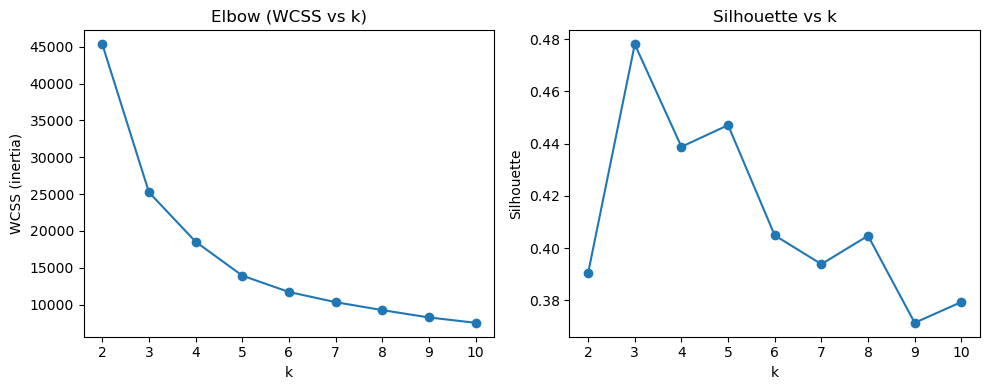

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# 肘部图
plt.subplot(1,2,1)
plt.plot(ks, inertias, marker="o")
plt.title("Elbow (WCSS vs k)")
plt.xlabel("k"); plt.ylabel("WCSS (inertia)")

# 轮廓系数
plt.subplot(1,2,2)
plt.plot(ks, silhouettes, marker="o")
plt.title("Silhouette vs k")
plt.xlabel("k"); plt.ylabel("Silhouette")

plt.tight_layout()
plt.show()


In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans

# 取三列特征
feat = con.execute("SELECT id, log_sigma_margin, dir_hit_rate, win_rate FROM user_features_v2").df()

# 基本清洗：去除任何 NaN/Inf；也可改成填补
feat = feat.replace([np.inf, -np.inf], np.nan).dropna(subset=["log_sigma_margin","dir_hit_rate","win_rate"])

# 可选：对 sigma 做轻微截尾以减弱极端值影响（1%–99%）
q1, q99 = feat["log_sigma_margin"].quantile([0.01, 0.99])
feat["log_sigma_margin"] = feat["log_sigma_margin"].clip(q1, q99)

# 标准化（RobustScaler 抗极端值；也可用 StandardScaler）
scaler = RobustScaler()
X = scaler.fit_transform(feat[["log_sigma_margin","dir_hit_rate","win_rate"]].values)

# 设定聚类数 k（先试 3 或 4）
k = 3
kmeans = KMeans(n_clusters=k, n_init=20, random_state=0)
labels = kmeans.fit_predict(X)

# 带上标签
feat["cluster"] = labels
feat.head()


,id,log_sigma_margin,dir_hit_rate,win_rate,cluster
0,6CD4573E638C182CCC590628B58FF5DA,0.051751,0.259115,0.060547,2
1,6D802ECA84578083614DED45A04251D9,0.857274,0.148087,0.175818,2
2,6E97CD043C1331A559BFC647928F58B7,0.076721,0.355623,0.373860,0
3,6F605A62AB4A5E85537D85C9BFCFB556,0.088380,0.221849,0.268908,0
4,73B3AA9D010F08046C33EF2B8253A991,0.173996,0.199513,0.143552,2


In [44]:
import numpy as np, pandas as pd

features = ["log_sigma_margin", "dir_hit_rate", "win_rate"]

summary = (
    feat.groupby("cluster")[features]
        .agg(["count","mean","median","std"])
        .round(6)
)
display(summary)


log_sigma_margin                                 dir_hit_rate  \
                   count       mean     median       std        count   
cluster                                                                 
0                  14205   1.680868   0.271353  2.855763        14205   
1                  11604  12.406501  12.693879  2.784143        11604   
2                  24049   1.114774   0.288235  1.664970        24049   

                                      win_rate                                
             mean    median       std    count      mean    median       std  
cluster                                                                       
0        0.343419  0.333333  0.080189    14205  0.319273  0.299204  0.092409  
1        0.200190  0.201335  0.094759    11604  0.155161  0.152437  0.078736  
2        0.126865  0.119645  0.065012    24049  0.107175  0.101589  0.055479

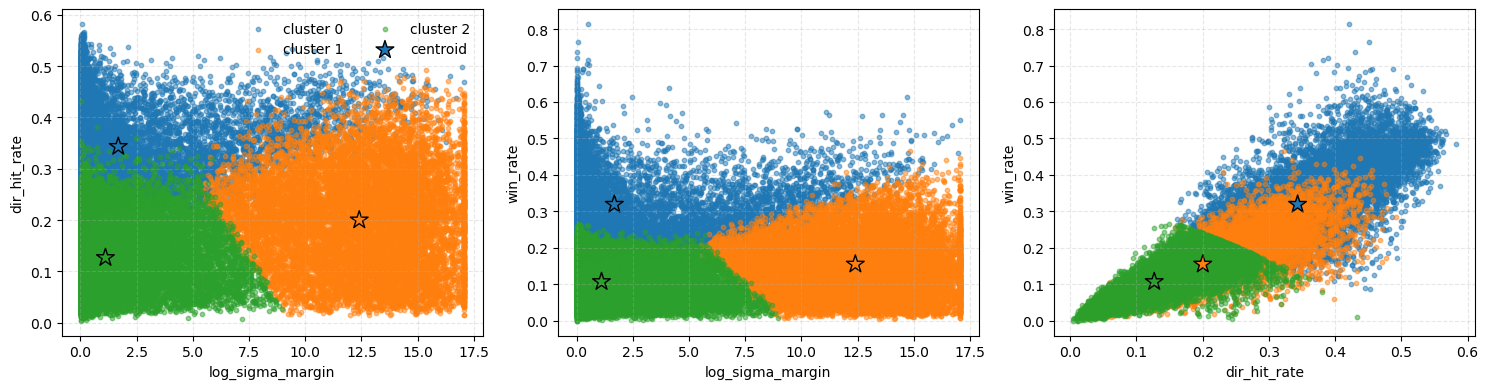

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# 质心：从标准化空间反变换回原始尺度，便于和散点同尺度展示
centers_std = kmeans.cluster_centers_
centers = pd.DataFrame(
    scaler.inverse_transform(centers_std),
    columns=features
)
centers["cluster"] = range(len(centers))

# 颜色表（3 类，可自行增减）
colors = np.array(["tab:blue","tab:orange","tab:green"])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

pairs = [
    ("log_sigma_margin", "dir_hit_rate"),
    ("log_sigma_margin", "win_rate"),
    ("dir_hit_rate", "win_rate"),
]

for ax, (x, y) in zip(axes, pairs):
    for c in sorted(feat["cluster"].unique()):
        m = (feat["cluster"] == c)
        ax.scatter(feat.loc[m, x], feat.loc[m, y], s=10, alpha=0.5, color=colors[c], label=f"cluster {c}" if x==pairs[0][0] and y==pairs[0][1] else "")
    # 质心
    ax.scatter(centers[x], centers[y], s=180, marker="*", edgecolor="k", linewidths=1.0, color=colors[centers["cluster"]], label="centroid")
    ax.set_xlabel(x); ax.set_ylabel(y)
    ax.grid(True, linestyle="--", alpha=0.3)

# 只在首图放图例，避免重复
axes[0].legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()


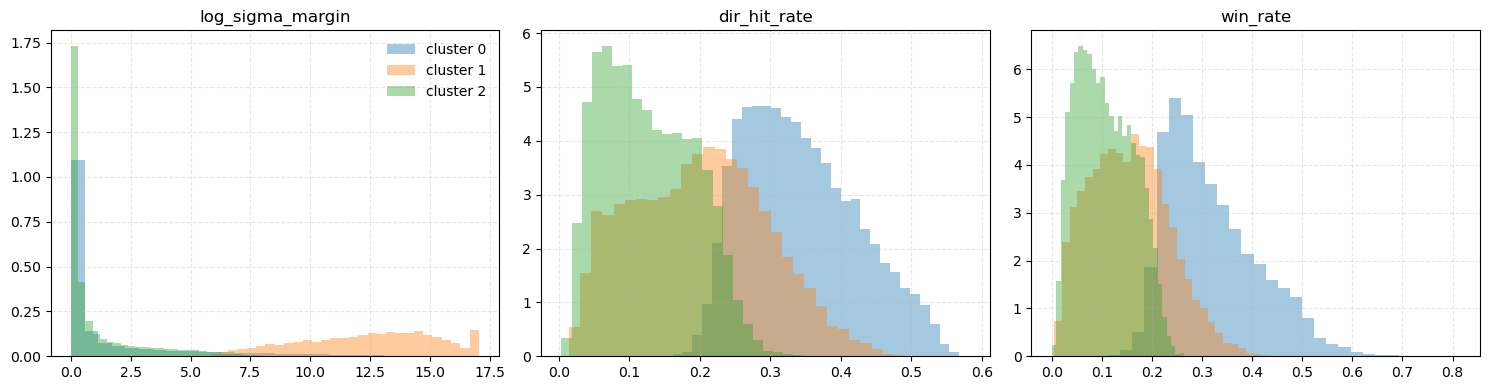

In [46]:
import matplotlib.pyplot as plt
import numpy as np

K = feat["cluster"].nunique()
colors = np.array(["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"])

fig, axes = plt.subplots(1, len(features), figsize=(15, 4))

bins = 30
for ax, col in zip(axes, features):
    for c in range(K):
        vals = feat.loc[feat["cluster"]==c, col].to_numpy()
        ax.hist(vals, bins=bins, alpha=0.4, density=True, color=colors[c], label=f"cluster {c}")
    ax.set_title(col)
    ax.grid(True, linestyle="--", alpha=0.3)

axes[0].legend(frameon=False)
plt.tight_layout()
plt.show()


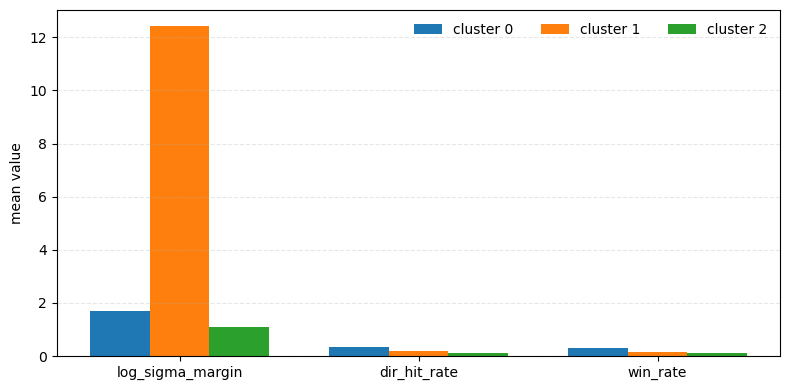

In [47]:
means = feat.groupby("cluster")[features].mean().sort_index()

fig, ax = plt.subplots(figsize=(8,4))
width = 0.25
x = np.arange(len(features))

for c in means.index:
    ax.bar(x + (c - means.index[0]) * width, means.loc[c, features], width=width, label=f"cluster {c}")

ax.set_xticks(x + width*(len(means.index)-1)/2)
ax.set_xticklabels(features)
ax.set_ylabel("mean value")
ax.grid(True, axis="y", linestyle="--", alpha=0.3)
ax.legend(frameon=False, ncol=len(means.index))
plt.tight_layout()
plt.show()


/Users/caiyan/miniconda3/envs/17303/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


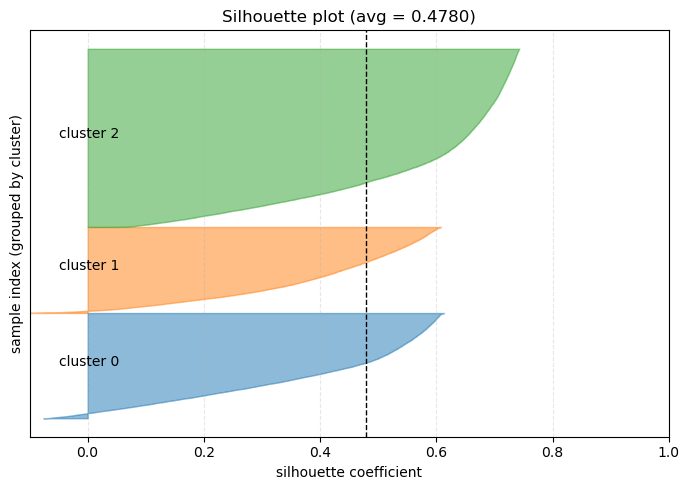

In [48]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# 用标准化后的 X 计算 silhouette（与训练 KMeans 的空间一致）
X = scaler.transform(feat[features])
labels = feat["cluster"].to_numpy()

sil_vals = silhouette_samples(X, labels)
sil_avg = silhouette_score(X, labels)

fig, ax = plt.subplots(figsize=(7,5))

y_lower = 10
for c in sorted(np.unique(labels)):
    m = (labels == c)
    sv = np.sort(sil_vals[m])
    size = sv.shape[0]
    y_upper = y_lower + size
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, sv, alpha=0.5, color=colors[c])
    ax.text(-0.05, y_lower + 0.5*size, f"cluster {c}")
    y_lower = y_upper + 10

ax.axvline(sil_avg, color="k", linestyle="--", linewidth=1)
ax.set_xlabel("silhouette coefficient")
ax.set_ylabel("sample index (grouped by cluster)")
ax.set_title(f"Silhouette plot (avg = {sil_avg:.4f})")
ax.set_xlim([-0.1, 1.0])
ax.set_yticks([])
ax.grid(True, axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


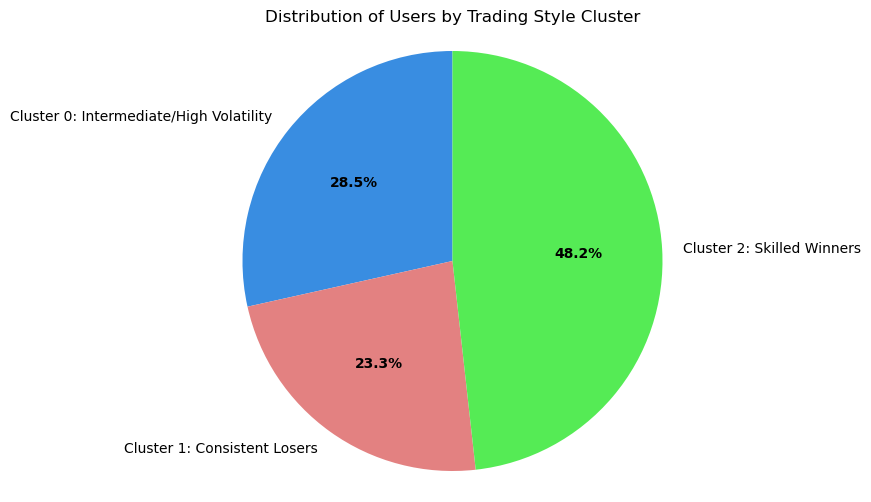

In [1]:
import matplotlib.pyplot as plt

# Data
sizes = [14205, 11604, 24049]
labels = ['Cluster 0: Intermediate/High Volatility', 'Cluster 1: Consistent Losers', 'Cluster 2: Skilled Winners']
colors = ["#398de1", "#e38181", "#55eb55"]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%',
                                  startangle=90, colors=colors, textprops=dict(color="black"))

# Styling
ax.axis('equal')
plt.title('Distribution of Users by Trading Style Cluster')
plt.setp(autotexts, size=10, weight="bold")

plt.savefig('cluster_user_distribution_pie.png')